<h1><center>CSCI - 4146 & 6409 - The Process of Data Science - Summer 2022</h1></center>
<h1><center>Assignment 2</h1></center>

<b>Meghna Kumar</b>  
B00892970 

<b>Vatsal Yadav</b>  
B00893030  

### 1.Data understanding and Feature Engineering

In [ ]:
import pandas as pnd
import numpy as np

# to store multiple files
import glob

#to ignore waenings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#to plot graphs and maps
from matplotlib import pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import learning_curve

from math import sqrt
# Evaluation Metrics
from sklearn.metrics import classification_report,confusion_matrix

# Decision Tree Classifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

#To perform statistical significance test
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_ind, ttest_rel
from mlxtend.evaluate import paired_ttest_5x2cv

from sklearn.metrics import accuracy_score

# Multi-layer Perceptron
from sklearn.neural_network import MLPClassifier

> **a. Extract the numerical and categorical features from the dataset and build
the data quality report**

> Read "Telco Customer Churn" <a href='https://docs.google.com/spreadsheets/d/1pzyq1-wUfS5Lo4044KM-vOzUGCNkmB9GynNW4PSKK_s/edit#gid=990980397'>[1]</a> Data csv file

In [ ]:
# Set options to avoid truncation when displaying a dataframe
# Code Reference: This code has been taken from CSCI 6709 Process of Data Science Tutorial 2 [2]
pnd.set_option("display.max_rows", None)
pnd.set_option("display.max_columns", None)
pnd.set_option('display.float_format', '{:.2f}'.format)

data_frame=[]
file = open("/CustomerChurnData.csv")
data_frame = pnd.read_csv(file)
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   PhoneService      7043 non-null   object 
 6   InternetService   7043 non-null   object 
 7   OnlineSecurity    7043 non-null   object 
 8   OnlineBackup      7043 non-null   object 
 9   DeviceProtection  7043 non-null   object 
 10  TechSupport       7043 non-null   object 
 11  StreamingTV       7043 non-null   object 
 12  StreamingMovies   7043 non-null   object 
 13  Contract          7043 non-null   object 
 14  PaperlessBilling  7043 non-null   object 
 15  PaymentMethod     7043 non-null   object 
 16  MonthlyCharges    7043 non-null   float64


> Build Continuous feature report

In [ ]:
#Code Reference: This code has been taken from CSCI 6709 Process of Data Science Tutorial 2 [2]
def build_continuous_features_report(data_df):
    
    """Build tabular report for continuous features"""

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Min": lambda df: df.min(),
        "1st Qrt.": lambda df: df.quantile(0.25),
        "Mean": lambda df: df.mean(),
        "Median": lambda df: df.median(),
        "3rd Qrt": lambda df: df.quantile(0.75),
        "Max": lambda df: df.max(),
        "Std. Dev.": lambda df: df.std(),
    }

    contin_feat_names = data_df.select_dtypes("number").columns
    continuous_data_df = data_df[contin_feat_names]

    report_df = pnd.DataFrame(index=contin_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

In [ ]:
build_continuous_features_report(data_frame)

,Count,Miss %,Card.,Min,1st Qrt.,Mean,Median,3rd Qrt,Max,Std. Dev.
SeniorCitizen,7043,0.00,2,0.00,0.00,0.16,0.00,0.00,1.00,0.37
MonthlyCharges,7043,0.00,1585,18.25,35.50,64.76,70.35,89.85,118.75,30.09
TotalCharges,7043,0.16,6530,18.80,401.45,2283.30,1397.47,3794.74,8684.80,2266.77


> Observations

*   TotalCharges has some missing values as the missing percentage in the report above is 0.16%
*   The cardinality of the SeniorCitizen is the lowest while TotalCharges has the highest cardinality
*   The standard deviation of the TotalCharges is the highest with 2266.77



> Build Categorical features report


In [ ]:
#Code Reference: This code has been taken from CSCI 6709 Process of Data Science Tutorial 2 [2]
def build_categorical_features_report(data_df):

    """Build tabular report for categorical features"""

    def _mode(df):
        return df.apply(lambda ft: ft.mode().to_list()).T

    def _mode_freq(df):
        return df.apply(lambda ft: ft.value_counts()[ft.mode()].sum())

    def _second_mode(df):
        return df.apply(lambda ft: ft[~ft.isin(ft.mode())].mode().to_list())

    def _second_mode_freq(df):
        return df.apply(
            lambda ft: ft[~ft.isin(ft.mode())]
            .value_counts()[ft[~ft.isin(ft.mode())].mode()]
            .sum()
        )

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Mode": _mode,
        "Mode Freq": _mode_freq,
        "Mode %": lambda df: _mode_freq(df) / len(df) * 100,
        "2nd Mode": _second_mode,
        "2nd Mode Freq": _second_mode_freq,
        "2nd Mode %": lambda df: _second_mode_freq(df) / len(df) * 100,
    }

    cat_feat_names = data_df.select_dtypes(exclude="number").columns
    continuous_data_df = data_df[cat_feat_names]

    report_df = pnd.DataFrame(index=cat_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

In [ ]:
build_categorical_features_report(data_frame)

,Count,Miss %,Card.,Mode,Mode Freq,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %
customerID,7043,0.00,7043,"[0002-ORFBO, 0003-MKNFE, 0004-TLHLJ, 0011-IGKF...",7043,100.00,[],0,0.00
gender,7043,0.00,2,[Male],3555,50.48,[Female],3488,49.52
Partner,7043,0.00,2,[No],3641,51.70,[Yes],3402,48.30
Dependents,7043,0.00,2,[No],4933,70.04,[Yes],2110,29.96
PhoneService,7043,0.00,2,[Yes],5016,71.22,[No],2027,28.78
InternetService,7043,0.00,3,[Fiber optic],2917,41.42,[DSL],2708,38.45
OnlineSecurity,7043,0.00,3,[No],3584,50.89,[Yes],2041,28.98
OnlineBackup,7043,0.00,3,[No],3543,50.31,[Yes],2082,29.56
DeviceProtection,7043,0.00,3,[No],3518,49.95,[Yes],2107,29.92
TechSupport,7043,0.00,3,[No],3547,50.36,[Yes],2078,29.50


> Observations

*   It is observed that the cardinality of 'CustomerID' is the same as the total count, hence, all the values of 'CustomerID' are unique
*   The rest of the attributes except 'Date' have the cardinality ranging between 2 to 4 and hence they can be converted into Continuous Features with one-hot encoding
*   The 'Date' attribute can be used to calculate the tenure of a customer



> **b. Identify data quality issues and build the data quality plan**

> Feature visualization - Continuous Features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2fb23967d0>,
      dtype=object)

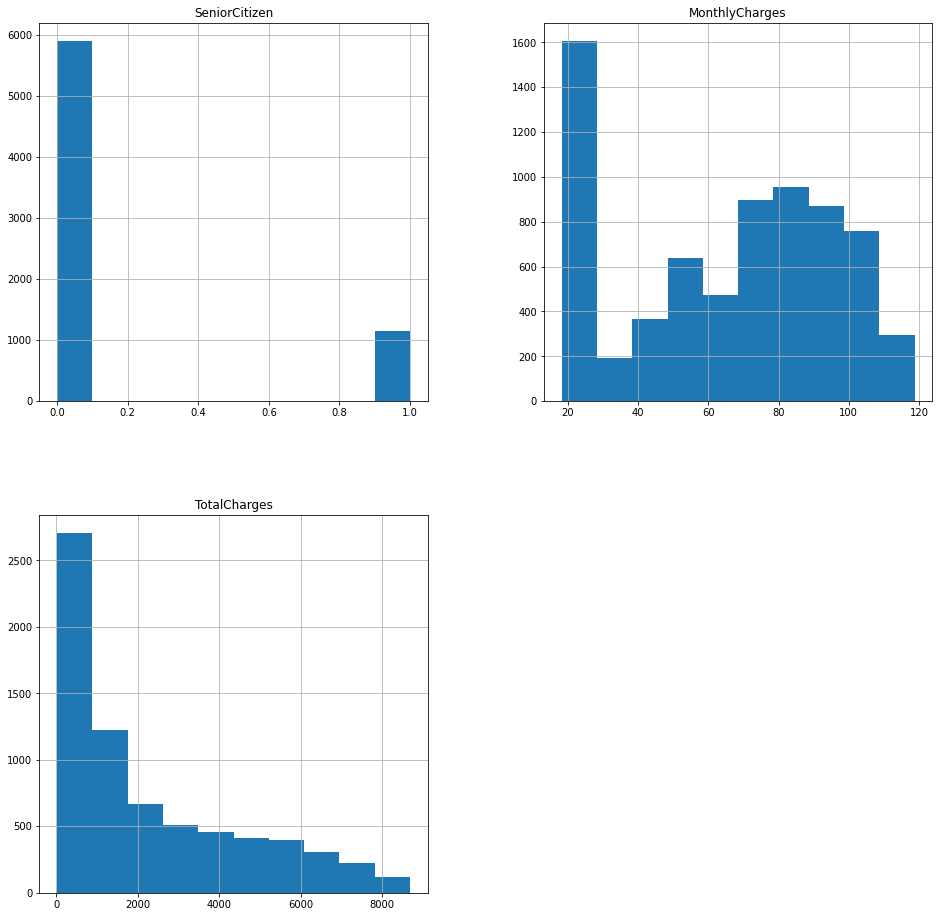

In [ ]:
data_frame.hist(column=(['SeniorCitizen', 'MonthlyCharges', 'TotalCharges']),figsize=(16,16))

> From the above visualizations for the continuous feature, the following observations can be made:

> From the histogram of 'SeniorCitizen' it can be observed -

*   Most of the customers do not fall in the category of Senior Citizen as the value at zero is very high
*   Only about 1100 customers are Senior Citizens with about 5900 customers at value zero

> From the histogram of 'MonthlyCharges' it can be observed -


*   The highest distribution  at a single value is at value 20 with about 1600 customers paying 20 as Monthly Charges
*   The number of customers falls abruptly after 20 with only about 200 customers paying 30. It then rises gradually between 30 and 50. 
*   The number of customers falls again at 60 monthly charges but then peaks at 90. It decreases after that with the maximum value paid by a customer being 118.75


> From the histogram of 'TotalCharges' it can be observed -


*   About 3000 customers pay a very low 'TotalCharges' with the number of customers falling significantly between 1000 and 2000 'TotalCharges'
*   The number of customers then fall gradually as the 'TotalCharges' increases




Feature Visualization - Categorical features

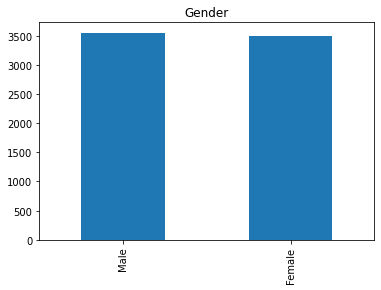

In [ ]:
data_frame['gender'].value_counts().plot.bar().set_title('Gender');

> Observation

> The ratio of customers on the basis of 'Gender' is approximately equal as seen in the graph above.

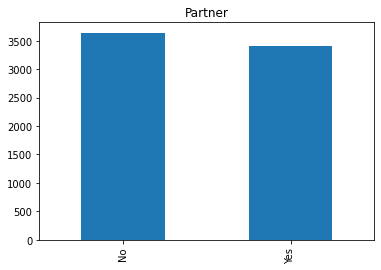

In [ ]:
data_frame['Partner'].value_counts().plot.bar().set_title('Partner');

> Observation

> The ratio of customers on the basis of 'Partner' is slightly higher for without partner than with partner.

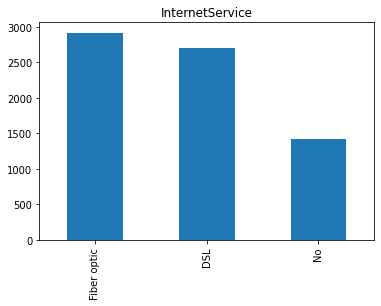

In [ ]:
data_frame['InternetService'].value_counts().plot.bar().set_title('InternetService');

> Observation

> From the visualization above it can be observed that most number of customers opt for 'Fiber optic'

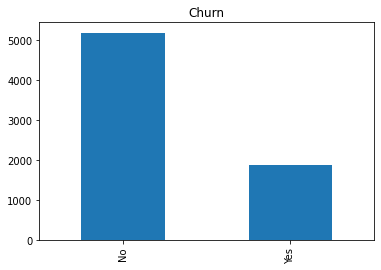

In [ ]:
data_frame['Churn'].value_counts().plot.bar().set_title('Churn');

> Observation

> It is observed that there is some imbalance in our target variable 'Churn'. The value of Churn is 'No' for approximately 5000 customers whereas only approximately 2000 customers have Churn as 'Yes'

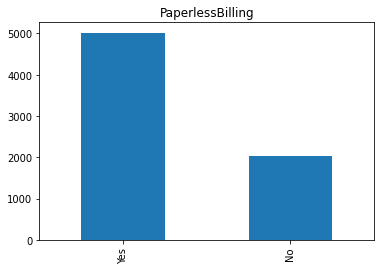

In [ ]:
data_frame['PaperlessBilling'].value_counts().plot.bar().set_title('PaperlessBilling');

> Observation

> From the above graph, it is observed that approximately 5000 customers prefer PaperlessBilling whereas around 2000 opt for PaperlessBilling.

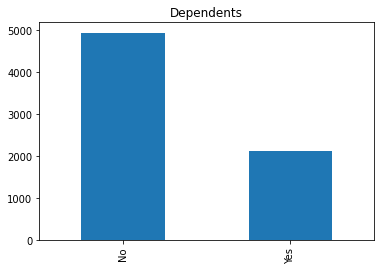

In [ ]:
data_frame['Dependents'].value_counts().plot.bar().set_title('Dependents');

> Observation

> Very few customers are Dependants and approximately 5000 customers are not dependants.

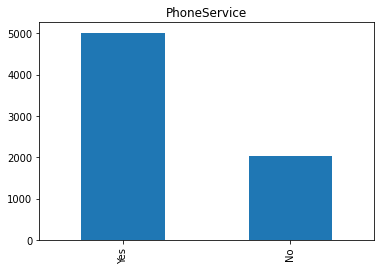

In [ ]:
data_frame['PhoneService'].value_counts().plot.bar().set_title('PhoneService');

> Observation

> Around 5000 customers have opted for PhoneService in comparison to the other 2000.

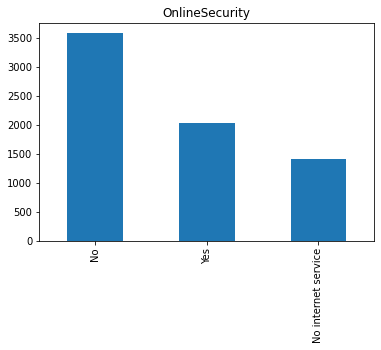

In [ ]:
data_frame['OnlineSecurity'].value_counts().plot.bar().set_title('OnlineSecurity');

> Observation

> Approximately 3500 customers don't have OnlineSecurity while around 2000 do have it. However, close to 1500 customers are not even having internet service.

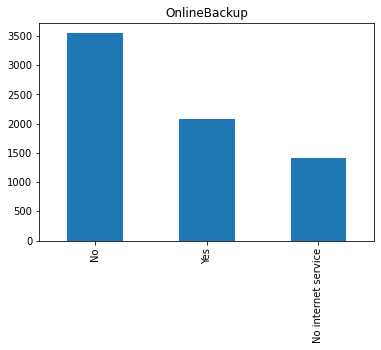

In [ ]:
data_frame['OnlineBackup'].value_counts().plot.bar().set_title('OnlineBackup');

> Observation

> Approximately 3500 customers don't have OnlineBackup while around 2000 do have it. However, close to 1500 customers are not even having internet service.

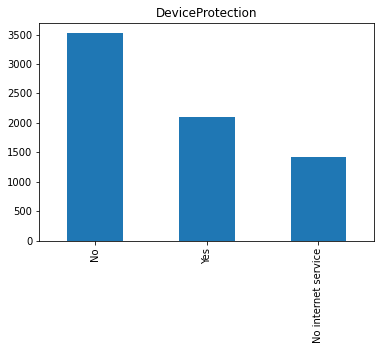

In [ ]:
data_frame['DeviceProtection'].value_counts().plot.bar().set_title('DeviceProtection');

> Observation

> Approximately 3500 customers don't have DeviceProtection while around 2000 do have it. However, close to 1500 customers are not even having an internet service.

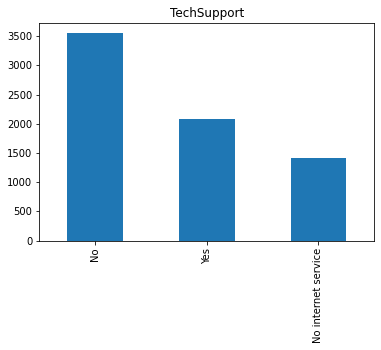

In [ ]:
data_frame['TechSupport'].value_counts().plot.bar().set_title('TechSupport');

> Observation

> Approximately 3500 customers don't have TechSupport while around 2000 do have it. However, close to 1500 customers are not even having an internet service.

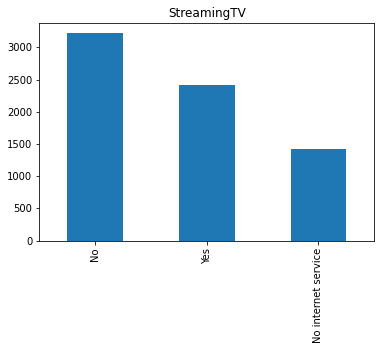

In [ ]:
data_frame['StreamingTV'].value_counts().plot.bar().set_title('StreamingTV');

> Observation

> Approximately 3200 customers don't have StreamingTV while around 2500 do have it. However, close to 1400 customers are not even having an internet service.

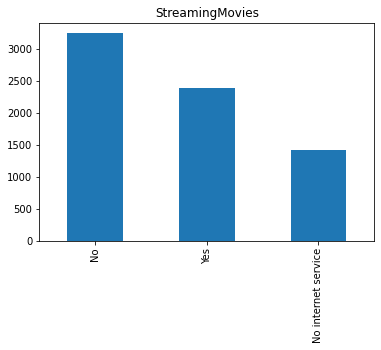

In [ ]:
data_frame['StreamingMovies'].value_counts().plot.bar().set_title('StreamingMovies');

> Observation

> Approximately 3200 customers don't have StreamingMovies while around 2500 do have it. However, close to 1400 customers are not even having an internet service.

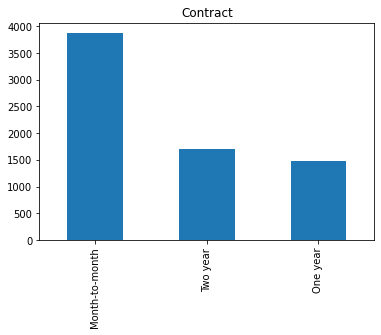

In [ ]:
data_frame['Contract'].value_counts().plot.bar().set_title('Contract');

> Observation

>* It is observed from the above graph that maximum number of customers enroll themselves for month-to-month contracts.
>* Number of customers almost look equal for Two year and One year plan contract

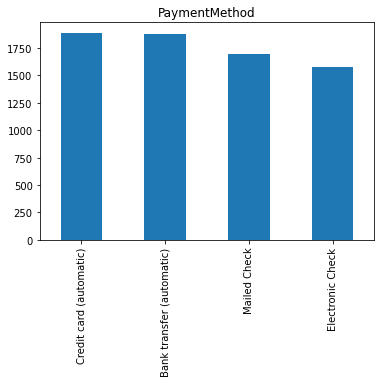

In [ ]:
data_frame['PaymentMethod'].value_counts().plot.bar().set_title('PaymentMethod');

> Observation

> There is not much difference between the customers opting for different PaymentMethod. However, customers preferring automatic mode of payment(Credit card and Bank transfer) are slighly more than Mailed check and Electronic check

**Identify data quality issues and build data quality plan**

The most common data quality issues are:

Missing values

Irregular cardinality

Outliers

Missing Values:

From the continuous and categorical features above we see that even though the count of all the columns is 7043, the missing percentage for 'totalCharges' is 0.16

Checking again if there are null values in data frame using isnull

In [ ]:
print("Boolean mask of missing values:\n",data_frame.isnull())

Streaming output truncated to the last 5000 lines.
2043          False           False         False  False  False  
2044          False           False         False  False  False  
2045          False           False         False  False  False  
2046          False           False         False  False  False  
2047          False           False         False  False  False  
2048          False           False         False  False  False  
2049          False           False         False  False  False  
2050          False           False         False  False  False  
2051          False           False         False  False  False  
2052          False           False         False  False  False  
2053          False           False         False  False  False  
2054          False           False         False  False  False  
2055          False           False         False  False  False  
2056          False           False         False  False  False  
2057          False      

From above it is observed that for the missing values the column has True. Hence, totalCharges has total of 11 missing values.

Remove all the missing values for totalCharges to have consistent data across the whole dataset.

Irregular cardinality:

General Issues with irregular cardinality are:

* Features with a cardinality of 1
* Too low cardinality continuous features
* Too high cardinality categorical features

With the above findings for categorical and continuous features, it is observed that - 
* there are no columns with cardinality 1
* only one continuous feature - SeniorCitizen has low cardinality. Even though SeniorCitizen has a cardinality of two we will not be dropping this column as this could help us understand the majority of people leaving are seniorCitizen or not.
* only one categorical feature - customerID has a very high cardinality and hence it can be dropped.


Outliers [2]

* Outliers are those values that lie completely away from all other values in the dataset.
* We'll be calculating the outliers for our features to check the number of outliers and remove them if a lot

Outliers for 'MonthlyCharges'

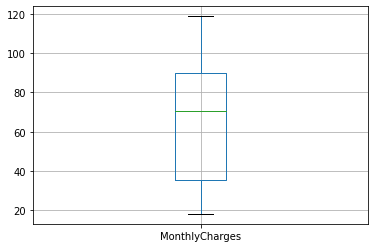

In [ ]:
df = data_frame
df.boxplot('MonthlyCharges')

In [ ]:
Q1= df['MonthlyCharges'].quantile(0.25)
Q3= df['MonthlyCharges'].quantile(0.75)

IQR = Q3-Q1
print(IQR)

54.349999999999994


In [ ]:
outliers_df = df[(df['MonthlyCharges'] < (Q1 - 1.5 * IQR)) | (df['MonthlyCharges'] > (Q3 + 1.5 * IQR))]
print("Num of outliers: ", len(outliers_df))

Num of outliers:  0


Outliers for TotalCharges

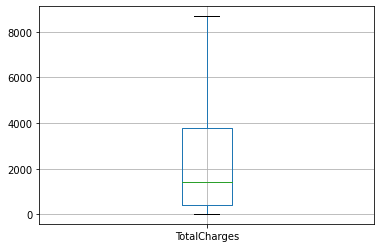

In [ ]:
df.boxplot('TotalCharges')

In [ ]:
Q1= df['TotalCharges'].quantile(0.25)
Q3= df['TotalCharges'].quantile(0.75)

IQR = Q3-Q1
print(IQR)

3393.2875000000004


In [ ]:
outliers_df = df[(df['TotalCharges'] < (Q1 - 1.5 * IQR)) | (df['TotalCharges'] > (Q3 + 1.5 * IQR))]
print("Num of outliers: ", len(outliers_df))

Num of outliers:  0


**c. Pre-processing data according to data quality plan**

1. Removing null values for totalCharges

- Taking all the null values where totalCharges is null to another dataframe.

In [ ]:
dataset_where_totalChargesNull = df[df['TotalCharges'].isna()]

In [ ]:
dataset_where_totalChargesNull.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Date
945,1371-DWPAZ,Female,0,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),56.05,NaN,No,"04 Jul, 2011"
1731,2520-SGTTA,Female,0,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed Check,20.00,NaN,No,"09 Oct, 2012"
1906,2775-SEFEE,Male,0,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),61.90,NaN,No,"13 Jan, 2013"
2025,2923-ARZLG,Male,0,Yes,Yes,Yes,DSL,No,No,No,No,No,No,One year,Yes,Credit card (automatic),19.70,NaN,No,"05 Apr, 2013"
2176,3115-CZMZD,Male,0,No,Yes,Yes,DSL,Yes,No,No,No,No,No,Two year,Yes,Electronic Check,20.25,NaN,No,"16 Jun, 2013"


- Above are the rows which have null values for TotalCharges

Dropping null values

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   PhoneService      7032 non-null   object 
 6   InternetService   7032 non-null   object 
 7   OnlineSecurity    7032 non-null   object 
 8   OnlineBackup      7032 non-null   object 
 9   DeviceProtection  7032 non-null   object 
 10  TechSupport       7032 non-null   object 
 11  StreamingTV       7032 non-null   object 
 12  StreamingMovies   7032 non-null   object 
 13  Contract          7032 non-null   object 
 14  PaperlessBilling  7032 non-null   object 
 15  PaymentMethod     7032 non-null   object 
 16  MonthlyCharges    7032 non-null   float64


- From the above information table it can be seen that the count for all the columns is same 7032 after dropping all the null values

Dropping 'customerID' feature

In [ ]:
df = df.drop(['customerID'], axis=1)

In [ ]:
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Date
0,Female,0,Yes,Yes,Yes,DSL,No,No,No,No,No,No,One year,Yes,Electronic Check,65.60,593.30,No,"01 Jan, 2010"
1,Male,0,No,No,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed Check,59.90,542.40,No,"01 Jan, 2010"


Feature Engineering - Converting our target variable 'Churn' to continuous feature 

In [ ]:
# Code Reference: https://github.com/aig3rim/Predict_customer_churn_multilayer_perceptron/blob/main/churn_prediction_MLP.ipynb [3]
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   PhoneService      7032 non-null   object 
 5   InternetService   7032 non-null   object 
 6   OnlineSecurity    7032 non-null   object 
 7   OnlineBackup      7032 non-null   object 
 8   DeviceProtection  7032 non-null   object 
 9   TechSupport       7032 non-null   object 
 10  StreamingTV       7032 non-null   object 
 11  StreamingMovies   7032 non-null   object 
 12  Contract          7032 non-null   object 
 13  PaperlessBilling  7032 non-null   object 
 14  PaymentMethod     7032 non-null   object 
 15  MonthlyCharges    7032 non-null   float64
 16  TotalCharges      7032 non-null   float64


In [ ]:
df.head(4)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Date
0,Female,0,Yes,Yes,Yes,DSL,No,No,No,No,No,No,One year,Yes,Electronic Check,65.60,593.30,0,"01 Jan, 2010"
1,Male,0,No,No,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed Check,59.90,542.40,0,"01 Jan, 2010"
2,Male,0,No,No,Yes,DSL,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),73.90,280.85,1,"01 Jan, 2010"
3,Male,1,Yes,No,Yes,DSL,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),98.00,1237.85,1,"02 Jan, 2010"


- Introducing another column 'tenure' to calculate duration of each employee as it is also needed in the next part and also Date will not serve any purpose in the model.


- Hence Date can be removed after calculating tenure

tenure = Number of months of the customer

In [ ]:
from datetime import datetime
current_date = datetime.today()
df['tenure'] = df.apply(lambda row: (current_date - datetime.strptime(row.Date, '%d %b, %Y')).days // 30, axis=1)

In [ ]:
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Date,tenure
0,Female,0,Yes,Yes,Yes,DSL,No,No,No,No,No,No,One year,Yes,Electronic Check,65.60,593.30,0,"01 Jan, 2010",152
1,Male,0,No,No,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed Check,59.90,542.40,0,"01 Jan, 2010",152
2,Male,0,No,No,Yes,DSL,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),73.90,280.85,1,"01 Jan, 2010",152
3,Male,1,Yes,No,Yes,DSL,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),98.00,1237.85,1,"02 Jan, 2010",152
4,Female,1,Yes,No,Yes,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Electronic Check,83.90,267.40,1,"03 Jan, 2010",152


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   PhoneService      7032 non-null   object 
 5   InternetService   7032 non-null   object 
 6   OnlineSecurity    7032 non-null   object 
 7   OnlineBackup      7032 non-null   object 
 8   DeviceProtection  7032 non-null   object 
 9   TechSupport       7032 non-null   object 
 10  StreamingTV       7032 non-null   object 
 11  StreamingMovies   7032 non-null   object 
 12  Contract          7032 non-null   object 
 13  PaperlessBilling  7032 non-null   object 
 14  PaymentMethod     7032 non-null   object 
 15  MonthlyCharges    7032 non-null   float64
 16  TotalCharges      7032 non-null   float64


**d. Explore the dataset to find patterns in the data**

Plotting a heatmap to observe the correlation between the variables in the dataset <a href='https://dal.brightspace.com/d2l/lms/dropbox/user/folders_history.d2l?db=151135&grpid=227472&isprv=0&bp=0&ou=221741'>[4]</a>

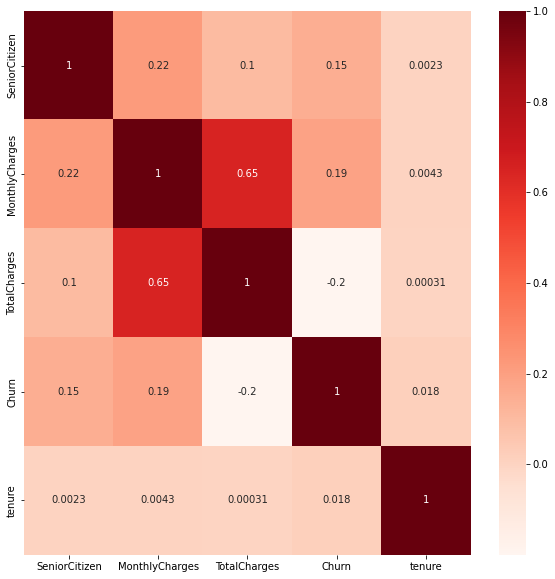

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True, cmap=plt.cm.Reds)

Observation from the heatmap

*   The colorbar on the right - Dark color indicates strong positive correlation and light color indicates strong negative correlation.
*  'MothlyCharges' and TotalCharges' have strong positive correlation between them.
*   'Churn' and 'TotalCharges' have strong negative correlation between them.






Tenure and Contract variables

> Below is a series of visualizations between tenure and all the contract variables. 

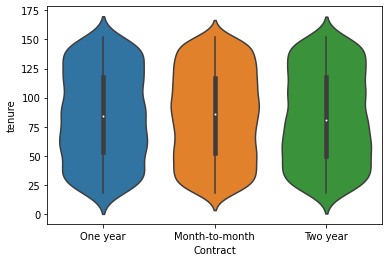

In [ ]:
sns.violinplot(x=df["Contract"], y=df["tenure"])

> From the above violin chart <a href='https://mode.com/blog/violin-plot-examples/#:~:text=A%20violin%20plot%20is%20a,the%20density%20of%20each%20variable'>[5]</a> for 'Contract', it can be observed that the median values of One year and Month-to-Month Contract while the median of Two year is slightly lower than the rest two.

> The data distribution can be observed by the density shown around the box plot in the center. 

>The data is similarly distributed for all three values with slight differences. Two year has slightly more distributions for Tenure below 75 while Month-to-Month Contract has the least density among all three below 75.


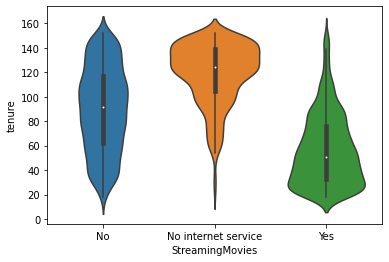

In [ ]:
sns.violinplot(x=df["StreamingMovies"], y=df["tenure"])

> From the above violin chart for 'StreamingMovies', it can be observed that the median values of No, No internet StreamingMovies and Yes are varying a lot with No internet StreamingMovies having the highest median and Yes having the lowest.

>The data is also unequally distributed for all three values. The data distribution for No increases gradually with the increase in tenure, peaks at about 100 months tenure and then decreases. The data for No internet StreamingMovies is highly concentrated for tenure greater than 110 while data for Yes is highly concentrated for tenure lower than 100.

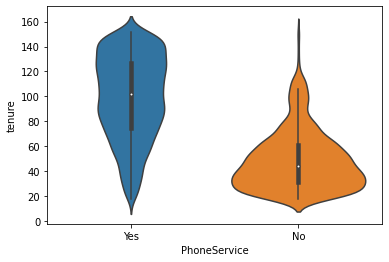

In [ ]:
sns.violinplot(x=df["PhoneService"], y=df["tenure"])

> From the above violin chart for 'PhoneService', it can be observed that the median values of Yes and No are varying a lot with Yes having a significantly higher median value than No.

>The data is also unequally distributed for both the values. The data distribution for Yes increases gradually with the increase in tenure, saturates with slight increase after 80 months and then decreases sharply after 145. The data for No is highly concentrated for tenure below 80 months and starts with a very sharp increase and then decreases after 20 months of tenure.

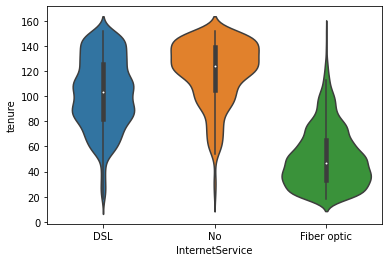

In [ ]:
sns.violinplot(x=df["InternetService"], y=df["tenure"])

From the above violin chart for 'InternetService', it can be observed that the median values of DSL, No InternetService and Fibre Optic are varying a lot with No InternetService having the highest median and Fibre Optic having the lowest.

The data is also unequally distributed for all three values. The data distribution for DSL increases gradually 40 tenure months, peaks between 80 and 100 and then decreases. The data for No InternetService is highly concentrated for tenure greater than 110 while data for Yes is highly concentrated for tenure lower than 60.

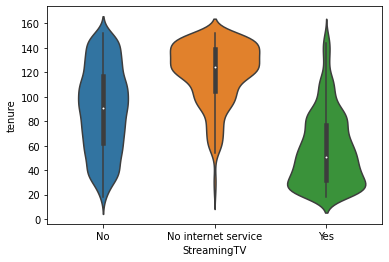

In [ ]:
sns.violinplot(x=df["StreamingTV"], y=df["tenure"])

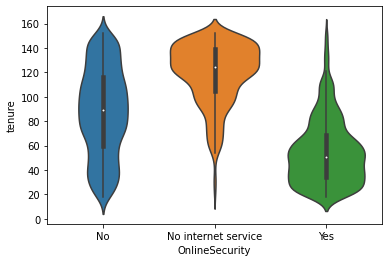

In [ ]:
sns.violinplot(x=df["OnlineSecurity"], y=df["tenure"])

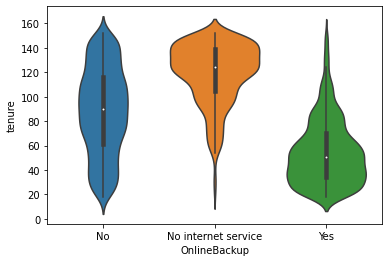

In [ ]:
sns.violinplot(x=df["OnlineBackup"], y=df["tenure"])

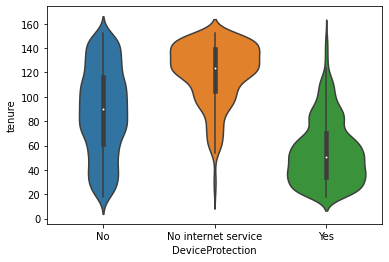

In [ ]:
sns.violinplot(x=df["DeviceProtection"], y=df["tenure"])

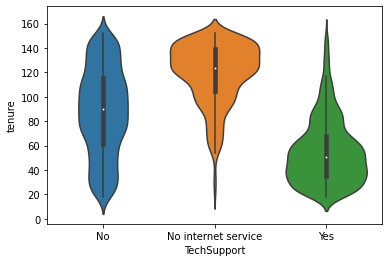

In [ ]:
sns.violinplot(x=df["TechSupport"], y=df["tenure"])

> The violin charts for 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', and 'StreamingTV' portray a very similar data distribution. It can be observed that the median value of No for all of them is at about 90 months of tenure. The No internet service for 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', and 'StreamingTV' have the highest median values in their charts, with values around 120 while Yes has the lowest median at about 50.

> The data is also unequally distributed for all three values in these charts. The data distribution for No increases gradually with the increase in tenure, peaks at about 80 months, and stabilizes till 110 before decreasing gradually. The data for No internet service is highly concentrated for tenure greater than 110 while data for Yes is highly concentrated for tenure lower than 60. However, the distribution of Yes is slightly different for 'StreamingTV' which has high where the values peak almost immediately and have a high concentration between 20 and 30 months of tenure and then decreases gradually.


### Baseline Model

**a. Explain what the task you’re solving is (e.g., supervised x unsupervised,
classification x regression x clustering or similarity matching x, etc)**
> The task that is being solved is **Supervised Classification** because the target feature that needs to be predicted - 'Churn' is a feature is a discrete value which only has two possible values - 0 and 1 and supervised classification is used to predict/classify discrete values.

**b. Use a feature selection method to select the features to build a model.**

> Apply one-hot encoding to convert categorical features to continuous features.

In [ ]:
df = pnd.get_dummies(df, columns=['gender','Partner'])
df = pnd.get_dummies(df, columns=['Dependents','PhoneService','InternetService'])
df = pnd.get_dummies(df, columns=['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling'])
df = pnd.get_dummies(df, columns=['SeniorCitizen', 'PaymentMethod'])

> Since 'tenure' has already been calculated using 'Date' and current date, 'Date' is no longer required hence dropping it from the dataset.

In [ ]:
df = df.drop(['Date'], axis=1)

> Add target variable 'Churn' to y and remaining features to X.

In [ ]:
y = df['Churn']
X = df.drop('Churn', axis=1)

> Perform data standardization on 'tenure',	'MonthlyCharges', and	'TotalCharges' <a href='https://github.com/aig3rim/Predict_customer_churn_multilayer_perceptron/blob/main/churn_prediction_MLP.ipynb'>[3]</a>

> Performing feature scaling to make sure that all the values in the dataset are at same level.

In [ ]:
X['MonthlyCharges'] = np.log(X['MonthlyCharges'])
X['MonthlyCharges'] = (X['MonthlyCharges'] - X['MonthlyCharges'].mean()) / X['MonthlyCharges'].std()
X['TotalCharges'] = np.log(X['TotalCharges'])
X['TotalCharges'] = (X['TotalCharges'] - X['TotalCharges'].mean()) / X['TotalCharges'].std()
X['tenure'] = (X['tenure'] - X['tenure'].mean()) / X['tenure'].std()
pnd.options.display.float_format = "{:.5f}".format
X[['tenure', 'MonthlyCharges', 'TotalCharges']].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.00000,7032.00000,7032.00000
mean,0.00000,0.00000,-0.00000
std,1.00000,1.00000,1.00000
min,-1.72629,-1.88227,-2.57906
25%,-0.87034,-0.75837,-0.60806
50%,-0.01440,0.38851,0.19505
75%,0.86749,0.80048,0.83823
max,1.74937,1.26958,1.37132


> Splitting the dataset into test train first - with 30% as test and 70% as train data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                   random_state=23)

> Further splitting the train dataset into train and Validation with 40% as train and 30% as validation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.3,
                                                   random_state=23)

**c. Select the evaluation metric. Justify your choice.**

We have selected Confusion Matrix as the evaluation metric as the model that is being built is a classification model and to evaluate the performance of the model we need a metric that evaluates the precision of the predicted values with the actual values. We'll use the components of the confusion matrix to evaluate the model.

> A confusion matrix is a n x n matrix (where n is the number of labels) used to describe the performance of a classification model. Each row in the confusion matrix represents an actual class whereas each column represents a predicted class. <a href='https://www.analyticsvidhya.com/blog/2021/12/evaluation-of-classification-model/'>[6]</a>


* Precision - How many are actually true from  all the predicted outputs
* Recall - How many were retrieved by the model from all the actual Positive cases
* F1 score - F1 score is a hybrid of precision and recall, which provides the Harmonic mean of Precision and Recall



> Building the baseline model design using Decision Tree Classifier

In [ ]:
params_tuned = {'min_samples_split': [2, 3, 4, 5, 7], 'min_samples_leaf': [1, 2, 3, 4, 6], 'max_depth': [2, 3, 4, 5, 6, 7]}
baseline_model = RandomizedSearchCV(DecisionTreeClassifier(), params_tuned, n_iter=20, scoring = 'neg_mean_absolute_error', cv=10, n_jobs=-1)
baseline_model.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7],
                                        'min_samples_leaf': [1, 2, 3, 4, 6],
                                        'min_samples_split': [2, 3, 4, 5, 7]},
                   scoring='neg_mean_absolute_error')

In [ ]:
y_train_pred=baseline_model.predict(X_train)

In [ ]:
y_pred=baseline_model.predict(X_val)

> Calculating Confusion matrix for evaluating the model

In [ ]:
# Code Reference: https://www.pluralsight.com/guides/machine-learning-neural-networks-scikit-learn> [7]
print(confusion_matrix(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))

[[2311  236]
 [ 454  444]]
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      2547
           1       0.65      0.49      0.56       898

    accuracy                           0.80      3445
   macro avg       0.74      0.70      0.72      3445
weighted avg       0.79      0.80      0.79      3445



In [ ]:
print(confusion_matrix(y_val,y_pred))
print(classification_report(y_val,y_pred))

[[959 124]
 [215 179]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1083
           1       0.59      0.45      0.51       394

    accuracy                           0.77      1477
   macro avg       0.70      0.67      0.68      1477
weighted avg       0.76      0.77      0.76      1477



**d. Perform hyperparameter tuning if applicable.**

> For the training and validation set the accuracy score is seen to be the value of 80 and 77 respectively. 

> Performing hyperparameter tuning using best parameters observed after performing best_estimator_ function on the baseline model.

In [ ]:
baseline_model.best_estimator_

DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, min_samples_split=3)

> Rebuilding the baseline model after hyperparameter tuning

In [ ]:
params_tuned = {'min_samples_split': [7], 'min_samples_leaf': [6], 'max_depth': [4]}
bestEstimator_baselineModel = RandomizedSearchCV(DecisionTreeClassifier(), params_tuned, n_iter=20, scoring = 'neg_mean_absolute_error', cv=10, n_jobs=-1)
bestEstimator_baselineModel.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [4],
                                        'min_samples_leaf': [6],
                                        'min_samples_split': [7]},
                   scoring='neg_mean_absolute_error')

**e. Train and evaluate your model on test data.**

In [ ]:
y_train_pred=bestEstimator_baselineModel.predict(X_train)

In [ ]:
y_pred=bestEstimator_baselineModel.predict(X_val)

> Calculate confusion matix after applying hyperparameter tuning

In [ ]:
print(confusion_matrix(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))

[[2311  236]
 [ 454  444]]
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      2547
           1       0.65      0.49      0.56       898

    accuracy                           0.80      3445
   macro avg       0.74      0.70      0.72      3445
weighted avg       0.79      0.80      0.79      3445



In [ ]:
print(confusion_matrix(y_val,y_pred))
print(classification_report(y_val,y_pred))

[[959 124]
 [215 179]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1083
           1       0.59      0.45      0.51       394

    accuracy                           0.77      1477
   macro avg       0.70      0.67      0.68      1477
weighted avg       0.76      0.77      0.76      1477



> Predicting the target value using the testing dataset and then evaluating the confusion matrix for it.

In [ ]:
y_pred_test = bestEstimator_baselineModel.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

[[1377  156]
 [ 281  296]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1533
           1       0.65      0.51      0.58       577

    accuracy                           0.79      2110
   macro avg       0.74      0.71      0.72      2110
weighted avg       0.78      0.79      0.78      2110



**f. How do you make sure that your model is not overfitting the data?**

> Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data <a href='https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms'>[8]</a>. 

> For our scenario, the accuracy of model on training is 80% and on test data it is 79%. Since the difference between the accuracy of the model is not significantly huge and hence it can be concluded that the model is not overfitting.

> In general, to avoid overfitting of a model, a hyperparameter tuning can be performed on the model or less/more number of features can be used.

**g. Plot the learning curve. What can you conclude from this plot?**

<BarContainer object of 43 artists>

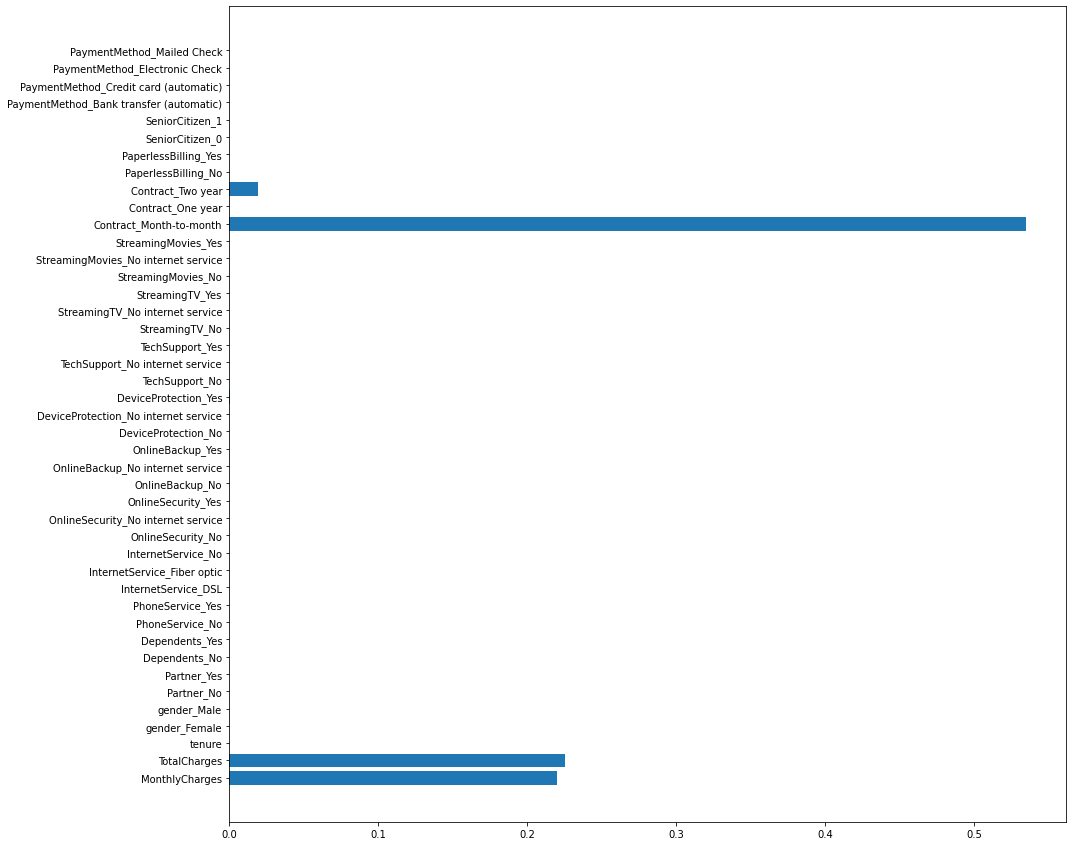

In [ ]:
plt.figure(figsize=(15, 15))
plt.barh(X_train.columns,bestEstimator_baselineModel.best_estimator_.feature_importances_)

> Observation

> From the above visualisation it can be observed that 'Contract_Month-to-month' is the most important feature with 'TotalCharges' and 'MonthlyCharges' being almost equal in terms of importance. 

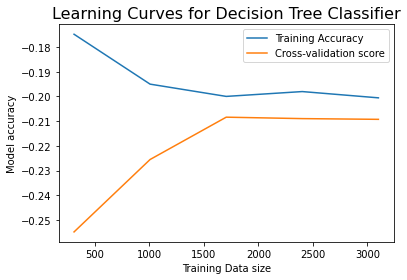

In [ ]:
plt.title("Learning Curves for Decision Tree Classifier", fontsize=16)
train_sizes, train_score, test_score, fit_times, _ = learning_curve(bestEstimator_baselineModel, X_train, y_train,cv=10, return_times=True)
plt.xlabel("Training Data size")
plt.ylabel("Model accuracy")
plt.plot(train_sizes,np.mean(train_score,axis=1), label = 'Training Accuracy')
plt.plot(train_sizes, np.mean(test_score, axis=1),label = 'Cross-validation score')
plt.legend(loc='upper right')

> A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error <a href='https://stackoverflow.com/a/67014482'>[9]</a>.

> From the Learning Curve graph for Decision Tree Classifier, it can be observed that the curves for the Training Accuracy and Cross-Validation are fairly close with a difference of ~0.01 after the 1500 training data size. It shows that the model is fairly trained and will perform decently on predicting things it hasn't seen before as it is on things it was trained on.

**h. Analyze and discuss model performance.**

> Train results for Decision Tree Classifier:

* The precision results for 0 target value is 0.84 and for 1 target value is 0.65. 
* The recall results are observed to be 0.91 for 0 target value and 0.49 for 1.
* The accuracy for the train dataset is 80%.

> Validation results for Decision Tree Classifier:

* The precision results for 0 target value is 0.82 and for 1 target value is 0.59. 
* The recall results are observed to be 0.89 for 0 target value and 0.45 for 1.
* The accuracy for the train dataset is 77%.

> Test results for Decision Tree Classifier:

* The precision results for 0 target value is 0.83 and for 1 target value is 0.65. 
* The recall results are observed to be 0.90 for 0 target value and 0.51 for 1.
* The accuracy for the train dataset is 79%.

> From the accuracy scores for all three datasets train, validation and test, it can be concluded that the model has a decent and consistent performance.

###Building NN Model

> We will be using Multi-layer Perceptron <a href='https://scikit-learn.org/stable/modules/neural_networks_supervised.html'>[10]</a> to perform supervised classification on the Churn data.

> Build the NN model

In [ ]:
# Code reference: https://scikit-learn.org/stable/modules/neural_networks_supervised.html [10]
NN_model = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(50, 90), random_state=23)
NN_model.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(50, 90), random_state=23,
              solver='lbfgs')

In [ ]:
y_train_pred=NN_model.predict(X_train)

In [ ]:
y_pred_val=NN_model.predict(X_val)

In [ ]:
y_pred_test = NN_model.predict(X_test)

> Calculating Confusion matrix for evaluating the model

In [ ]:
print(confusion_matrix(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))

[[2516   31]
 [  45  853]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2547
           1       0.96      0.95      0.96       898

    accuracy                           0.98      3445
   macro avg       0.97      0.97      0.97      3445
weighted avg       0.98      0.98      0.98      3445



In [ ]:
print(confusion_matrix(y_val,y_pred_val))
print(classification_report(y_val,y_pred_val))

[[892 191]
 [216 178]]
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1083
           1       0.48      0.45      0.47       394

    accuracy                           0.72      1477
   macro avg       0.64      0.64      0.64      1477
weighted avg       0.72      0.72      0.72      1477



In [ ]:
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

[[1286  247]
 [ 303  274]]
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1533
           1       0.53      0.47      0.50       577

    accuracy                           0.74      2110
   macro avg       0.67      0.66      0.66      2110
weighted avg       0.73      0.74      0.74      2110



> Performing hyperparameter tuning since the accuracy score of training set data is quite high than the validation and test set data, which might result in overfitting. The hyperparameter tuning is being performed by reducing the hidden layer sizes when building the model to avoid overfitting.

In [ ]:
NN_model = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1)
NN_model.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [ ]:
y_train_pred=NN_model.predict(X_train)

In [ ]:
y_pred_val=NN_model.predict(X_val)

In [ ]:
y_pred_test = NN_model.predict(X_test)

> Calculating Confusion matrix for evaluating the model

In [ ]:
print(confusion_matrix(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))

[[2318  229]
 [ 424  474]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2547
           1       0.67      0.53      0.59       898

    accuracy                           0.81      3445
   macro avg       0.76      0.72      0.73      3445
weighted avg       0.80      0.81      0.80      3445



In [ ]:
print(confusion_matrix(y_val,y_pred_val))
print(classification_report(y_val,y_pred_val))

[[963 120]
 [226 168]]
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1083
           1       0.58      0.43      0.49       394

    accuracy                           0.77      1477
   macro avg       0.70      0.66      0.67      1477
weighted avg       0.75      0.77      0.75      1477



In [ ]:
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

[[1372  161]
 [ 303  274]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1533
           1       0.63      0.47      0.54       577

    accuracy                           0.78      2110
   macro avg       0.72      0.68      0.70      2110
weighted avg       0.77      0.78      0.77      2110



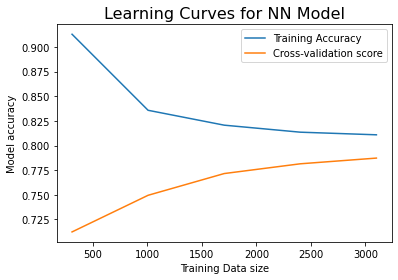

In [ ]:
plt.title("Learning Curves for NN Model", fontsize=16)
train_sizes, train_score, test_score, fit_times, _ = learning_curve(NN_model, X_train, y_train,cv=10, return_times=True)
plt.xlabel("Training Data size")
plt.ylabel("Model accuracy")
plt.plot(train_sizes,np.mean(train_score,axis=1), label = 'Training Accuracy')
plt.plot(train_sizes, np.mean(test_score, axis=1),label = 'Cross-validation score')
plt.legend(loc='upper right')

> From the Learning Curve graph for NN Model, it can be observed that the curves for the Training Accuracy and Cross-Validation are fairly close with a difference of ~0.05 after the 2000 training data size. It shows that the model is fairly trained and will perform decently on predicting things it hasn't seen before as it is on things it was trained on.

> **NN Model Observations:**

> Train results for NN Model:

* The precision results for 0 target value is 0.85 and for 1 target value is 0.67. 
* The recall results are observed to be 0.91 for 0 target value and 0.53 for 1.
* The accuracy for the train dataset is 81%.

> Validation results for NN Model:

* The precision results for 0 target value is 0.81 and for 1 target value is 0.58. 
* The recall results are observed to be 0.89 for 0 target value and 0.43 for 1.
* The accuracy for the train dataset is 77%.

> Test results for NN Model:

* The precision results for 0 target value is 0.82 and for 1 target value is 0.63. 
* The recall results are observed to be 0.89 for 0 target value and 0.47 for 1.
* The accuracy for the train dataset is 78%.

> From the accuracy scores for all three datasets train, validation and test, it can be concluded that the model has a decent and consistent performance.

> Calculate cross-validation score of both the models

In [ ]:
# Code Refernce: https://scikit-learn.org/stable/modules/cross_validation.html [11]
baseline_cv = cross_validate(bestEstimator_baselineModel, X_train, y_train, cv=10, scoring='accuracy')
baseline_cv['test_score']

array([0.79130435, 0.79130435, 0.76521739, 0.79130435, 0.79130435,
       0.79360465, 0.81104651, 0.80523256, 0.76453488, 0.80232558])

In [ ]:
NN_model_cv = cross_validate(NN_model, X_train, y_train, cv=10, scoring='accuracy')
NN_model_cv['test_score']

array([0.7826087 , 0.77101449, 0.75652174, 0.8       , 0.7826087 ,
       0.80523256, 0.80523256, 0.7994186 , 0.79069767, 0.81976744])

**Statistical Significance Test**

* Performed a paired t-test on both the models for comparing them.
* Comparison is done on the basis of p-value evaluated

In [ ]:
# Code Reference: http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_resampled/ [12]
from mlxtend.evaluate import paired_ttest_resampled
t,p = paired_ttest_resampled(estimator1=bestEstimator_baselineModel,estimator2=NN_model, X=X_test, y=y_test, random_seed = 1)
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 4.782
p value: 0.000


* Since the value of p is less than 0.05, the models are different from each other


> Comparing the two models by plotting a box plot between their cross-validation score <a href='https://www.projectpro.io/recipes/compare-sklearn-classification-algorithms-in-python#mcetoc_1g1oehhmkb'>[13]</a>.

In [ ]:
from sklearn import model_selection
results = []
kfold = model_selection.KFold(n_splits=10)
cv_results = model_selection.cross_val_score(bestEstimator_baselineModel, X_train, y_train, cv=kfold, scoring='accuracy')
results.append(cv_results)
cv_results_NN = model_selection.cross_val_score(NN_model, X_train, y_train, cv=kfold, scoring='accuracy')
results.append(cv_results_NN)

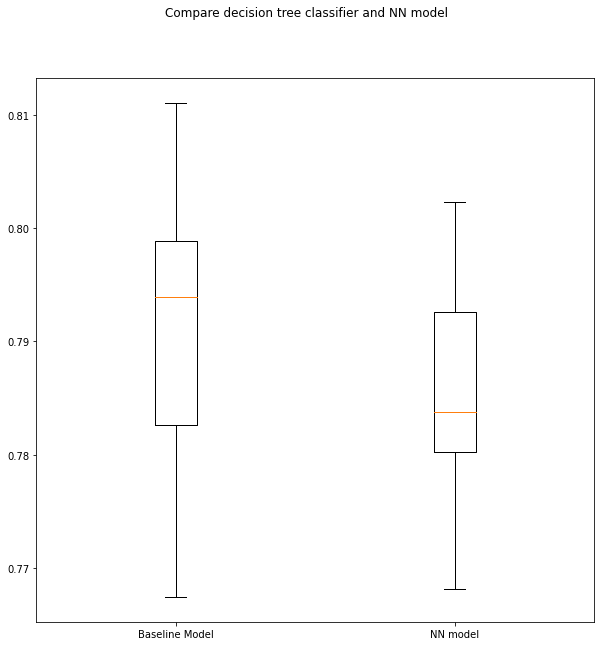

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Compare decision tree classifier and NN model')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(['Baseline Model','NN model'])
plt.show()

### Concept Drift Detection

> Concept drift is when the relationship of the target variable, which the model is trying to predict, changes overtime with the input features. Concept drift leads to low accuracy of the model as the time progresses.

In [ ]:
!pip install scikit-multiflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 3.9 MB/s 


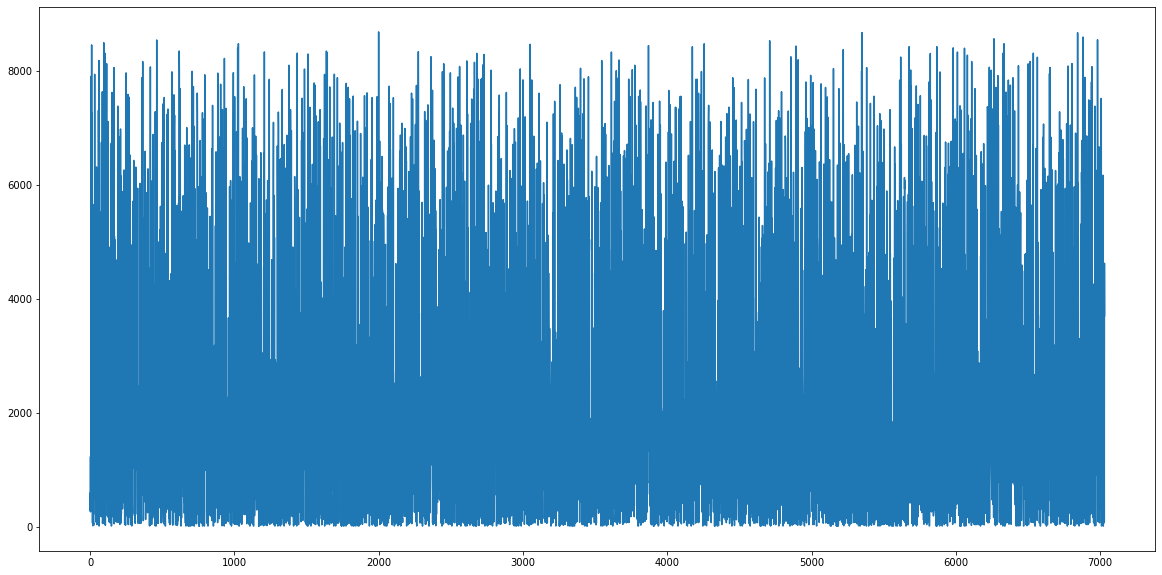

In [ ]:
from skmultiflow.drift_detection import ADWIN
adwin = ADWIN()
df_drift = df['TotalCharges']
df_drift = np.array(df_drift)
plt.figure(figsize=(20, 10))
plt.plot(df_drift)
for i in range(df_drift.size):
    adwin.add_element(df_drift[i])
    if adwin.detected_change():
        print('Change detected in data: ' + str(df_drift[i]) + ' - at index: ' + str(i) +'for column:')

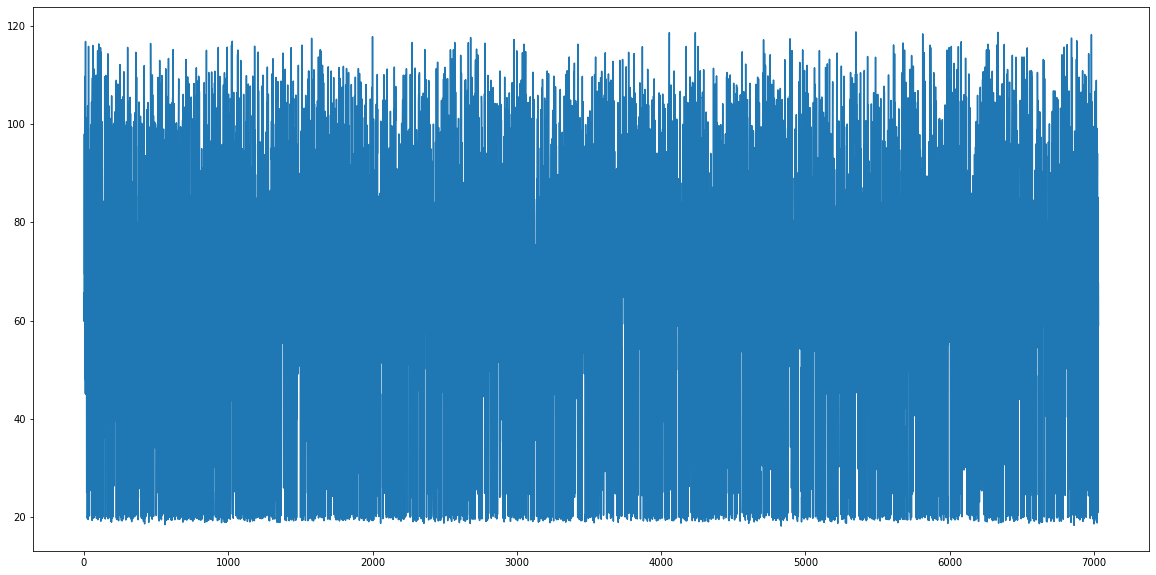

In [ ]:
from skmultiflow.drift_detection import ADWIN
adwin = ADWIN()
df_drift = df['MonthlyCharges']
df_drift = np.array(df_drift)
plt.figure(figsize=(20, 10))
plt.plot(df_drift)
for i in range(df_drift.size):
    adwin.add_element(df_drift[i])
    if adwin.detected_change():
        print('Change detected in data: ' + str(df_drift[i]) + ' - at index: ' + str(i) +'for column: MonthlyCharges')

> We have calculated the concept drift for 'TotalCharges' and 'MonthlyCharges' using ADWIN for our dataset and no drift was observed for either of the features. 

> In case if there was a drift detected for the target feature, we could have mitigated the loss of accuracy by applying the following ways:


*   Periodically Re-Fit: Periodically update the model with a more recent historical data
*   Periodically Update: Periodically update the model by using the existing state as the starting point for a fit process that updates the model fit using a sample of the most recent historical data <a href='https://machinelearningmastery.com/gentle-introduction-concept-drift-machine-learning/'>[14]</a>
*   Weight data: Applying weight that is inversely proportional to the age of the data and with higher weight assigned to the more recent data.



### References

[1] "Telco Customer Churn Data", 2022 [online] Available at: https://docs.google.com/spreadsheets/d/1pzyq1-wUfS5Lo4044KM-vOzUGCNkmB9GynNW4PSKK_s/edit#gid=990980397 [Accessed 12 July 2022].

[2] Maksym Taranukhin, “CSCI 4146/6409 Process of Data Science Tutorial 2.” Summer Term, Dalhousie University, [online document], 2022. [Accessed 12 July 2022]

[3] "Churn prediction with multilayer perceptron model (MLP)", GitHub, 2022. [Online]. Available: https://github.com/aig3rim/Predict_customer_churn_multilayer_perceptron/blob/main/churn_prediction_MLP.ipynb. [Accessed: 12 July 2022].

[4] Meghna Kumar and Vatsal Yadav, “CSCI 4146/6409 Process of Data Science Assignment 1” Summer Term, Dalhousie University, [online document], 2022. [Accessed 12 July 2022]

[5] Mode.com. 2022. Violin Plots 101: Visualizing Distribution and Probability Density | Mode. [online] Available at: https://mode.com/blog/violin-plot-examples/#:~:text=A%20violin%20plot%20is%20a,the%20density%20of%20each%20variable. [Accessed 12 July 2022].


[6] Analytics Vidhya. 2022. Evaluation of Classification Model - Analytics Vidhya. [online] Available at: <https://www.analyticsvidhya.com/blog/2021/12/evaluation-of-classification-model/> [Accessed 12 July 2022].

[7] Singh, D. and scikit-learn, M., 2022. Machine Learning with Neural Networks Using scikit-learn | Pluralsight. [online] Pluralsight.com. Available at: <https://www.pluralsight.com/guides/machine-learning-neural-networks-scikit-learn> [Accessed 12 July 2022].

[8] Brownlee, J., 2022. Overfitting and Underfitting With Machine Learning Algorithms. [online] Machine Learning Mastery. Available at: <https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/> [Accessed 12 July 2022].

[9] W. and Jones, H., 2022. What does the learning curve in classification decision tree mean?. [online] Stack Overflow. Available at: <https://stackoverflow.com/a/67014482> [Accessed 12 July 2022].

[10] scikit-learn. 2022. 1.17. Neural network models (supervised). [online] Available at: <https://scikit-learn.org/stable/modules/neural_networks_supervised.html> [Accessed 12 July 2022].

[11] "Cross-validation: evaluating estimator performance", scikit-learn, 2022. [Online]. Available: https://scikit-learn.org/stable/modules/cross_validation.html. [Accessed: 12 July 2022].

[12] Raschka, S., 2022. paired_ttest_resample: Resampled paired t test - mlxtend. [online] Rasbt.github.io. Available at: http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_resampled/ [Accessed 12 July 2022].

[13] ProjectPro. 2022. How to compare sklearn classification algorithms in Python? -. [online] Available at: <https://www.projectpro.io/recipes/compare-sklearn-classification-algorithms-in-python#mcetoc_1g1oehhmkb> [Accessed 12 July 2022].

[14] Brownlee, J., 2022. A Gentle Introduction to Concept Drift in Machine Learning. [online] Machine Learning Mastery. Available at: <https://machinelearningmastery.com/gentle-introduction-concept-drift-machine-learning/> [Accessed 12 July 2022].





